In [ ]:
!pip install -Uqq fastai
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [ ]:
# Import fast.ai dependencies
#from fastcore.all import *
#from fastdownload import download_url
from fastai.vision.all import *
from fastbook import *

# import utilities
import time
import os
import pathlib
import shutil

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Image Download

In [ ]:
# Download images of different image categories and save
def download_images_ddg(img_category, img_type, path, num_images):
   # To Delete and Create New Directory Each Time The Function is Run
    #if path.exists():
    #  shutil.rmtree(path)
    #  path.mkdir()
    # To not redownload images
    if not path.exists():
      path.mkdir()
      for img_type in img_types:
          dest = (path/img_type)
          dest.mkdir(exist_ok=True)
          results = search_images_ddg(f'{str(img_type)} b{search_term}', max_images=num_images)
          for u in range(len(results)):
              try:
                  download_url(url=results[u],
                                dest=f'{dest}/{str(img_type)}-{str(u+1)}.jpg',
                                timeout=10,
                                show_progress=False)
              except:
                  print(f'not found {results[u]}')
                  continue

In [ ]:
# Define image category and image types and pth to storage location
img_category = 'bears'
search_term = 'bear photos'
img_types = ['grizzly','black', 'teddy']
lesson_path = '/content/drive/MyDrive/Colab Notebooks/FastaiCourseData/Lesson_2/'
path = Path(f'{lesson_path}/{img_category}')

In [ ]:
# Call function to download images for each image type
for img_type in img_types:
 download_images_ddg(img_category, img_type, path, num_images=100)

In [ ]:
# Check for failed images
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);
len(failed)

0

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)#.dataloaders(path, bs=32)

dls = bears.dataloaders(path, bs=32)

dls.show_batch(max_n=24)

Output hidden; open in https://colab.research.google.com to view.

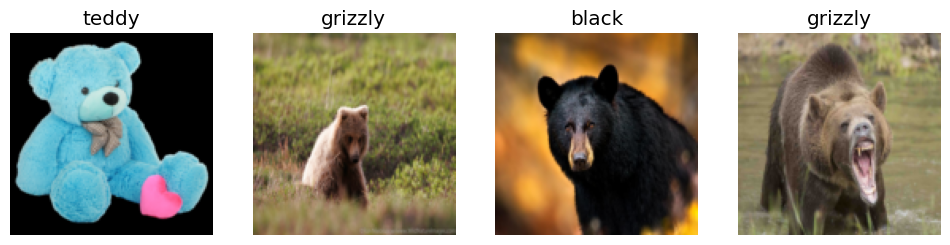

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

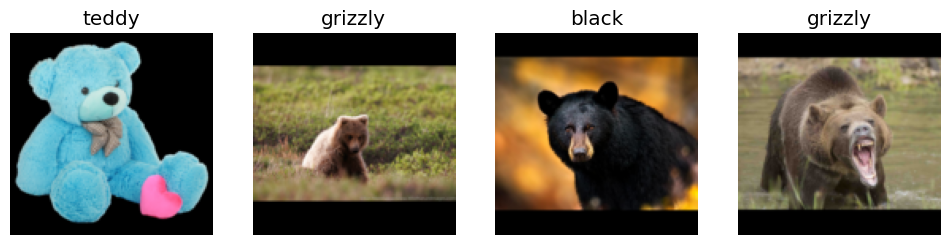

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

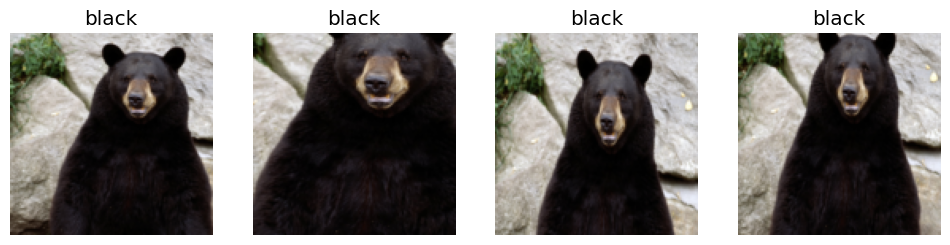

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

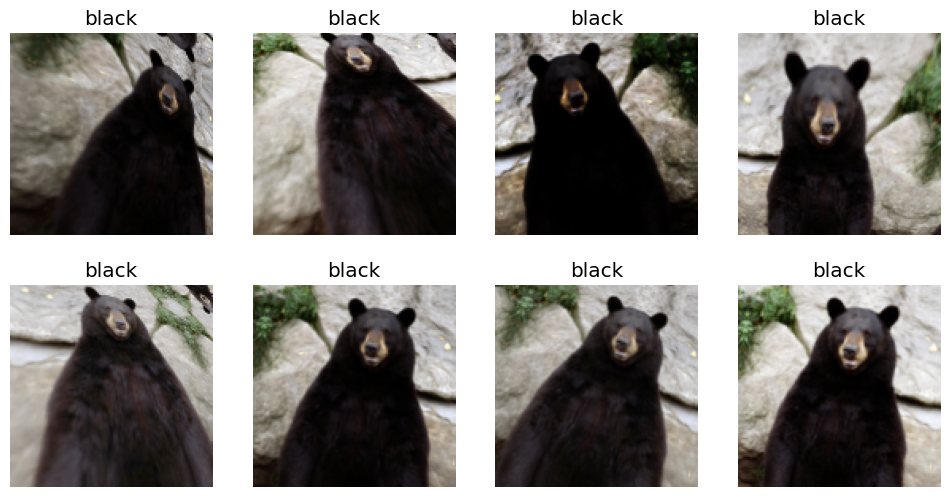

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

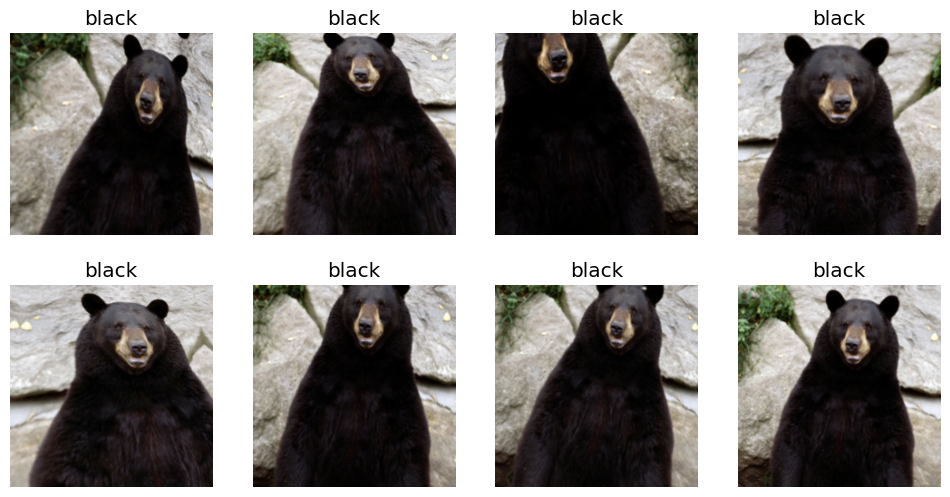

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.5MB/s]


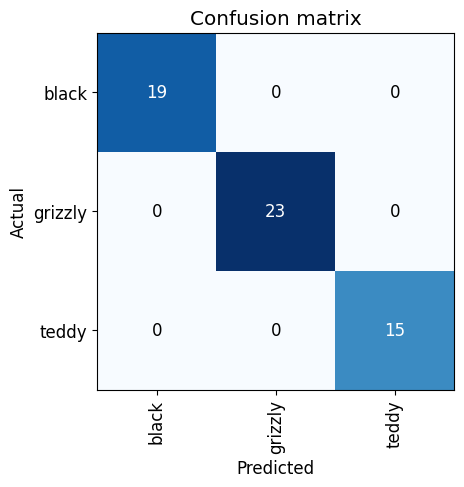

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

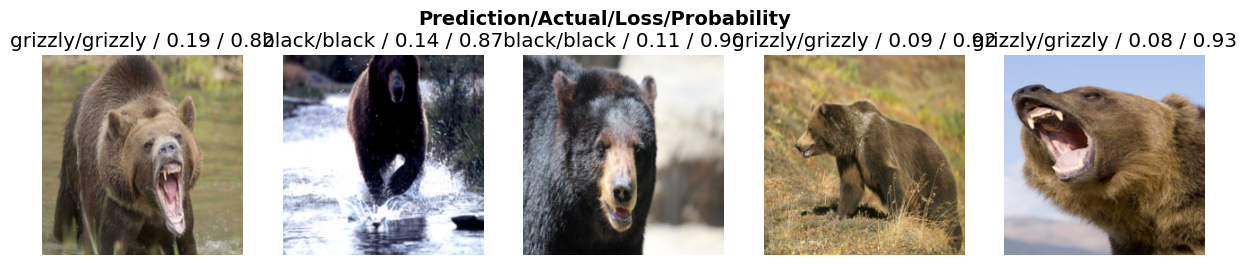

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export('/content/drive/MyDrive/Colab Notebooks/FastaiColabNotebooks/Lesson_2/BearDetector/model.pkl')

In [ ]:
print(path)

/content/drive/MyDrive/Colab Notebooks/FastaiCourseData/Lesson_2/bears
